# Tuning the model

## Load the data

In [1]:
import os

import h5py
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
data_path = "./CHB-MIT/processed"
ictal_path = os.path.join(data_path, "ictal.h5")
interictal_path = os.path.join(data_path, "interictal.h5")

ictal_file = h5py.File(ictal_path, 'r')
interictal_file = h5py.File(interictal_path, 'r')

print(ictal_file.keys())
print(interictal_file.keys())

<KeysViewHDF5 ['channels', 'data', 'info']>
<KeysViewHDF5 ['channels', 'data', 'info']>


## Convert data to tensor

In [3]:
ictal_np = np.array(ictal_file['data'])
interictal_np = np.array(interictal_file['data'])

ictal_data = torch.tensor(ictal_np, dtype=torch.float32)
interictal_data = torch.tensor(interictal_np, dtype=torch.float32)

print(f"Ictal data shape {ictal_data.shape}")
print(f"Interictal data shape {interictal_data.shape}")

Ictal data shape torch.Size([2509, 22, 2048])
Interictal data shape torch.Size([2509, 22, 2048])


## Create Dataset

In [4]:
class EEGDataset(Dataset):
    def __init__(self, ictal_data, interictal_data):
        # Ensure the data is converted to tensors
        self.data = torch.cat([ictal_data, interictal_data])
        # Labels for ictal and interictal data
        self.labels = torch.cat(
            [
                torch.ones(len(ictal_data)),  # Ictal = 1
                torch.zeros(len(interictal_data)),  # Interictal = 0
            ]
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        eeg_raw = self.data[idx]  # EEG data of shape (22, 2048)
        label = self.labels[idx].bool()  # Label: 0 (interictal) or 1 (ictal)
        return eeg_raw, label

In [5]:
dataset = EEGDataset(ictal_data, interictal_data)
train_dataset, test_dataset, val_dataset = random_split(dataset, [0.7, 0.2, 0.1])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [6]:
subset_labels = ("Train", "Test", "Validation")

for i, data in enumerate([train_dataset, test_dataset, val_dataset]):
    label_counts = {0: 0, 1: 0}

    for idx in data.indices:
        label = data.dataset.labels[idx].item()
        label_counts[label] += 1

    total = sum(label_counts.values())
    
    print(f"Dataset: {subset_labels[i]}")
    print(f"  Total samples: {total}")
    print(f"  Ictal (seizure): {label_counts[1]} ({label_counts[1]/total:.2%})")
    print(f"  Interictal (normal): {label_counts[0]} ({label_counts[0]/total:.2%})")
    print(f"  Ratio: {label_counts[1]/label_counts[0]:.2f}")
    print("-" * 40)

Dataset: Train
  Total samples: 3513
  Ictal (seizure): 1770 (50.38%)
  Interictal (normal): 1743 (49.62%)
  Ratio: 1.02
----------------------------------------
Dataset: Test
  Total samples: 1004
  Ictal (seizure): 496 (49.40%)
  Interictal (normal): 508 (50.60%)
  Ratio: 0.98
----------------------------------------
Dataset: Validation
  Total samples: 501
  Ictal (seizure): 243 (48.50%)
  Interictal (normal): 258 (51.50%)
  Ratio: 0.94
----------------------------------------


## Testing the model
From this sample model the data is not time domain but the frequency so it need to do the sfft

In [7]:
import snntorch as snn
import torch
import torch.nn as nn
from snntorch import SConv2dLSTM, surrogate
from tqdm import tqdm

In [8]:
def vectorized_stft(eeg_data, n_fft=256, hop_length=32, win_length=128):
    """
    Apply STFT to batched EEG data using vectorization

    Parameters:
    -----------
    eeg_data: torch.Tensor
        EEG data with shape (batch, channels, time_steps)

    Returns:
    --------
    stft_output: torch.Tensor
        STFT output with shape (batch, channels, frequency_bins, time_frames)
    """
    batch_size, n_channels, time_steps = eeg_data.shape
    window = torch.hann_window(win_length)

    # Reshape to (batch*channels, time_steps)
    reshaped_data = eeg_data.reshape(-1, time_steps)

    # Apply STFT to all channels at once
    stft = torch.stft(
        reshaped_data,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        return_complex=True,
    )

    # Reshape back to (batch, channels, freq_bins, time_frames)
    freq_bins, time_frames = stft.shape[1], stft.shape[2]
    stft_output = stft.reshape(batch_size, n_channels, freq_bins, time_frames)

    return stft_output

In [9]:
class STFTSpikeClassifier(nn.Module):
    def __init__(
        self,
        input_channels=22,
        threshold=0.05,
        slope=13.42287274232855,
        beta=0.9181805491303656,
        p1=0.5083664100388336,
        p2=0.26260898840708335,
    ):
        super().__init__()

        spike_grad = surrogate.straight_through_estimator()
        spike_grad2 = surrogate.fast_sigmoid(slope=slope)

        # initialize layers - note input_channels=22 for your STFT data
        self.lstm1 = SConv2dLSTM(
            in_channels=input_channels,
            out_channels=16,
            kernel_size=3,
            max_pool=(2, 1),
            threshold=threshold,
            spike_grad=spike_grad,
        )
        self.lstm2 = SConv2dLSTM(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            max_pool=(2, 1),
            threshold=threshold,
            spike_grad=spike_grad,
        )
        self.lstm3 = snn.SConv2dLSTM(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            max_pool=(2, 1),
            threshold=threshold,
            spike_grad=spike_grad,
        )

        # Calculate the flattened size based on your frequency dimension (129)
        # After 3 max-pooling layers (each dividing by 2), size becomes: 129 → 64 → 32 → 16
        # For time dimension: 1 (we process one time step at a time)
        self.fc1 = nn.Linear(
            64 * 16 * 1, 512
        )  # Adjust this based on actual output size

        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad2, threshold=threshold)
        self.dropout1 = nn.Dropout(p1)
        self.fc2 = nn.Linear(512, 2)  # Assuming binary classification
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad2, threshold=threshold)
        self.dropout2 = nn.Dropout(p2)

    def forward(self, x):
        # x shape: (batch, channels=22, freq=129, time=57)
        time_steps = x.size(3)

        # Initialize LIF state variables
        mem4 = self.lif1.init_leaky()
        mem5 = self.lif2.init_leaky()
        syn1, mem1 = self.lstm1.init_sconv2dlstm()
        syn2, mem2 = self.lstm2.init_sconv2dlstm()
        syn3, mem3 = self.lstm3.init_sconv2dlstm()

        # Output recording
        spk5_rec = []
        mem5_rec = []

        # Process each time step
        for step in range(time_steps):
            # Extract the current time step and prepare input
            # x_t shape: (batch, channels=22, freq=129, time=1)
            x_t = x[:, :, :, step].unsqueeze(-1)

            # Pass through SConv2dLSTM layers
            spk1, syn1, mem1 = self.lstm1(x_t, syn1, mem1)
            spk2, syn2, mem2 = self.lstm2(spk1, syn2, mem2)
            spk3, syn3, mem3 = self.lstm3(spk2, syn3, mem3)

            # Flatten and feed through fully connected layers
            cur4 = self.dropout1(self.fc1(spk3.flatten(1)))
            spk4, mem4 = self.lif1(cur4, mem4)

            cur5 = self.dropout2(self.fc2(spk4))
            spk5, mem5 = self.lif2(cur5, mem5)

            # Record output spikes and membrane potentials
            spk5_rec.append(spk5)
            mem5_rec.append(mem5)

        # Stack time steps
        return torch.stack(spk5_rec), torch.stack(mem5_rec)

In [10]:
import snntorch.functional as SF
from snntorch import spikegen

device = torch.device("cuda")

In [12]:
params = {
    "threshold": 0.029502183721464022,
    "slope": 5.877186513794134,
    "beta": 0.8878529652241832,
    "p1": 0.5158072293841036,
    "p2": 0.33379760536677766,
    "lr": 4.0554645367364053e-05,
    "weight_decay": 1.45773874831512e-06,
    "scheduler_factor": 0.5512718333066357,
    "scheduler_patience": 6,
    "encoding_method": "delta",
}

# Create model and optimizer
model = STFTSpikeClassifier(
    input_channels=22, threshold=params["threshold"], slope=params["slope"], beta=params["beta"], p1=params["p1"], p2=params["p2"]
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=params["lr"], betas=(0.9, 0.999), weight_decay=params["weight_decay"]
)

# Create scheduler with sampled parameters
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=params["scheduler_factor"],
    patience=params["scheduler_patience"],
    min_lr=1e-6,
)

criterion = SF.mse_count_loss()

In [13]:
# Training loop
num_epochs = 15  # Reduced for hyperparameter search
best_val_loss = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]")

    for batch_idx, (data, targets) in enumerate(train_loop):
        # Preprocess data
        scaled_data = vectorized_stft(data)

        encoding_method = params["encoding_method"]

        if encoding_method == "rate":
            scaled_data = torch.abs(scaled_data)

            if scaled_data.max() > 0:  # Avoid division by zero
                scaled_data = scaled_data / scaled_data.max()

            data_spike = spikegen.rate(scaled_data, time_var_input=True)
        elif encoding_method == "delta":
            # Get magnitude with sign from real part
            magnitude = torch.abs(scaled_data)
            sign = torch.sign(scaled_data.real)

            # Apply sign to magnitude to preserve direction
            signed_magnitude = magnitude * sign

            signed_magnitude = signed_magnitude / torch.max(magnitude)

            data_spike = spikegen.delta(signed_magnitude)

        data_spike, targets = data_spike.to(device), targets.to(device)

        spk_rec, _ = model(data_spike)

        loss_val = criterion(spk_rec, targets)

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        train_loss += loss_val.item()
        spike_sum = torch.sum(spk_rec, dim=0)
        _, predicted = torch.max(spike_sum, 1)
        total_train += targets.size(0)
        correct_train += (predicted == targets).sum().item()

        # Update progress bar
        train_loop.set_postfix(
            loss=train_loss / (batch_idx + 1), acc=100.0 * correct_train / total_train
        )

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]")

        for batch_idx, (data, targets) in enumerate(val_loop):
            # Preprocess data
            scaled_data = vectorized_stft(data)

            encoding_method = "rate"

            if encoding_method == "rate":
                scaled_data = torch.abs(scaled_data)

                if scaled_data.max() > 0:  # Avoid division by zero
                    scaled_data = scaled_data / scaled_data.max()

                data_spike = spikegen.rate(scaled_data, time_var_input=True)
            elif encoding_method == "delta":
                # Get magnitude with sign from real part
                magnitude = torch.abs(scaled_data)
                sign = torch.sign(scaled_data.real)

                # Apply sign to magnitude to preserve direction
                signed_magnitude = magnitude * sign

                signed_magnitude = signed_magnitude / torch.max(magnitude)

                data_spike = spikegen.delta(signed_magnitude)

            data_spike, targets = data_spike.to(device), targets.to(device)

            spk_rec, _ = model(data_spike)

            loss_val = criterion(spk_rec, targets)

            val_loss += loss_val.item()
            spike_sum = torch.sum(spk_rec, dim=0)
            _, predicted = torch.max(spike_sum, 1)
            total_val += targets.size(0)
            correct_val += (predicted == targets).sum().item()

            # Update progress bar
            val_loop.set_postfix(
                loss=val_loss / (batch_idx + 1), acc=100.0 * correct_val / total_val
            )

    # Calculate average metrics
    avg_val_loss = val_loss / len(val_loader)

    scheduler.step(avg_val_loss)

    if avg_val_loss > best_val_loss:
        best_val_loss = avg_val_loss

Epoch 15/15 [Val]: 100%|██████████| 16/16 [00:01<00:00, 10.51it/s, acc=54.9, loss=21.5]


In [35]:
def test_model(model, test_loader, encoding_method="rate"):
    """
    Test the SNN model using the provided test data loader.
    
    Args:
        model: The trained SNN model
        test_loader: DataLoader for the test dataset
        encoding_method: Encoding method to use ('rate' or 'delta')
        
    Returns:
        tuple: (all_targets, all_predictions) as numpy arrays
    """
    # Set model to evaluation mode
    model.eval()

    # Initialize variables
    all_targets = []
    all_predictions = []

    # Start testing
    with torch.no_grad():
        test_loop = tqdm(test_loader, desc=f"Testing [{encoding_method}]")

        for batch_idx, (data, targets) in enumerate(test_loop):
            # Preprocess data
            scaled_data = vectorized_stft(data)

            if encoding_method == "rate":
                scaled_data = torch.abs(scaled_data)

                if scaled_data.max() > 0:  # Avoid division by zero
                    scaled_data = scaled_data / scaled_data.max()

                data_spike = spikegen.rate(scaled_data, time_var_input=True)
            elif encoding_method == "delta":
                # Get magnitude with sign from real part
                magnitude = torch.abs(scaled_data)
                sign = torch.sign(scaled_data.real)

                # Apply sign to magnitude to preserve direction
                signed_magnitude = magnitude * sign

                signed_magnitude = signed_magnitude / torch.max(magnitude)

                data_spike = spikegen.delta(signed_magnitude)

            data_spike, targets = data_spike.to(device), targets.to(device)

            spk_rec, _ = model(data_spike)

            spike_sum = torch.sum(spk_rec, dim=0)
            _, predicted = torch.max(spike_sum, 1)
            
            # Store predictions and targets
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return np.array(all_targets), np.array(all_predictions)

In [37]:
y_test_rate, y_pred_rate = test_model(model, test_loader, encoding_method="rate")

Testing [rate]: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)


def print_metrics(y_true, y_pred):
    """
    Print classification metrics and plot confusion matrix.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues', 
                xticklabels=['Non-Seizure', 'Seizure'], 
                yticklabels=['Non-Seizure', 'Seizure'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f"Confusion Matrix - {encoding_method.capitalize()} Encoding")
    plt.show()

Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.78      0.83       520
        True       0.79      0.89      0.84       484

    accuracy                           0.83      1004
   macro avg       0.84      0.84      0.83      1004
weighted avg       0.84      0.83      0.83      1004

Accuracy: 0.8347
Precision: 0.7923
Recall: 0.8905
F1 Score: 0.8385


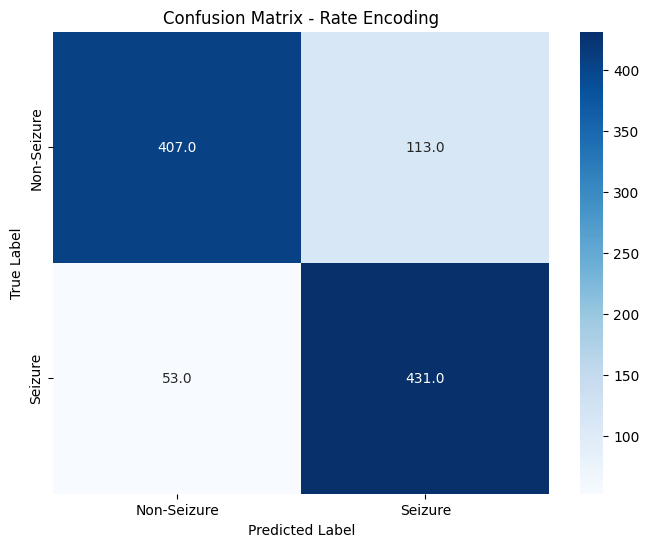

In [39]:
print_metrics(y_test_rate, y_pred_rate)